In [208]:
from casadi import *
%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline
from Dynamics import get_next_state, state_to_coords, get_energy
from Environment import DoublePendulumEnv, normalize_angle
from PPO.Proximal_Policy_Optimization import PPO, unscaled_action
from PPO.train import train

In [217]:
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
import gym
from torch.distributions import Normal
from gym.spaces import Box
import random
from IPython.display import clear_output
from torch.distributions import MultivariateNormal

In [260]:
env_name = 'DoubleInvPendulum'
directory = "PPO2_Trained" + '/' 
checkpoint_path = directory + "PPO_{}_400K.pth".format(env_name)
print("loading network from : " + checkpoint_path)

loading network from : PPO2_Trained/PPO_DoubleInvPendulum_400K.pth


In [286]:
state0 = np.array([0,np.pi/2,np.pi/2,
                0,0,0])
state = state0
state

array([0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        ])

In [287]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


max_ep_len = 200
action_std = 0.4
   
render = True
total_test_episodes = 50
K_epochs = 100
eps_clip = 0.2
gamma = 0.99

lr_actor = 3e-4
lr_critic = 0.001

env = DoublePendulumEnv(init_state = state, dt = 0.02)
observation_shape = 6
action_shape = 1

ppo_agent = PPO(observation_shape, action_shape, lr_actor, lr_critic, gamma, K_epochs, eps_clip,
                    action_std)

Environment initialized


In [288]:
ppo_agent.load(checkpoint_path)

In [289]:
state_t = torch.FloatTensor(state)
u = ppo_agent.select_action(state_t)

In [290]:
normalize_angle(state[2]) - np.pi/2

0.0

In [291]:
unscaled_action(u)

array([14.361244], dtype=float32)

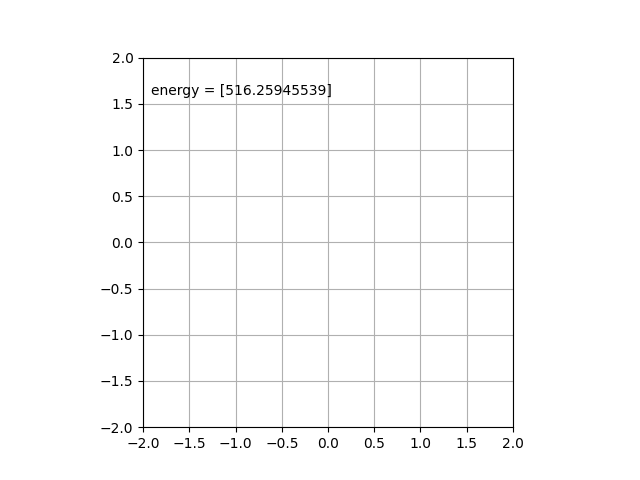

In [292]:
%matplotlib widget

state = state0
dt = 0.02

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line


def animate(i):
    """perform animation step"""
    global state, dt
    state_t = torch.FloatTensor(state)
    u = ppo_agent.select_action(state_t)
    action = unscaled_action(u)
    state = get_next_state(state,action,dt)
    XY = state_to_coords(state)
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=300,
                             interval=20, blit=True, init_func=init)

from IPython.display import HTML
HTML(ani.to_jshtml())